# Magnitude distributions for DR2 targets

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [14]:
import corner as cn
import desitarget.cuts

from astropy.io import fits
from astropy.table import Table
from sklearn.mixture import GMM
from desitarget.targetmask import desi_mask

In [3]:
class GaussianMixtureModel(object):

    def __init__(self, weights, means, covars, covtype):
        self.weights = weights
        self.means = means
        self.covars = covars
        self.covtype = covtype
        self.n_components, self.n_dimensions = self.means.shape
    
    @staticmethod
    def save(model, filename):
        hdus = fits.HDUList()
        hdr = fits.Header()
        hdr['covtype'] = model.covariance_type
        hdus.append(fits.ImageHDU(model.weights_, name='weights', header=hdr))
        hdus.append(fits.ImageHDU(model.means_, name='means'))
        hdus.append(fits.ImageHDU(model.covars_, name='covars'))
        hdus.writeto(filename, clobber=True)

    @staticmethod
    def load(filename):
        hdus = fits.open(filename, memmap=False)
        hdr = hdus[0].header
        covtype = hdr['covtype']
        model = GaussianMixtureModel(
            hdus['weights'].data, hdus['means'].data, hdus['covars'].data, covtype)
        hdus.close()
        return model
        
    def sample(self, n_samples=1, random_state=None):
        
        if self.covtype != 'full':
            return NotImplementedError(
                'covariance type "{0}" not implemented yet.'.format(self.covtype))
        
        # Code adapted from sklearn's GMM.sample()
        if random_state is None:
            random_state = np.random.RandomState()

        weight_cdf = np.cumsum(self.weights)
        X = np.empty((n_samples, self.n_dimensions))
        rand = random_state.rand(n_samples)
        # decide which component to use for each sample
        comps = weight_cdf.searchsorted(rand)
        # for each component, generate all needed samples
        for comp in range(self.n_components):
            # occurrences of current component in X
            comp_in_X = (comp == comps)
            # number of those occurrences
            num_comp_in_X = comp_in_X.sum()
            if num_comp_in_X > 0:
                X[comp_in_X] = random_state.multivariate_normal(
                    self.means[comp], self.covars[comp], num_comp_in_X)
        return X

In [4]:
def classify_targets(cuts):
    lrg_mask = cuts['DESI_TARGET'] & desi_mask.LRG
    elg_mask = cuts['DESI_TARGET'] & desi_mask.ELG
    qso_mask = cuts['DESI_TARGET'] & desi_mask.QSO
    lrgs = lrg_mask.astype(bool)
    elgs = elg_mask.astype(bool)
    qsos = qso_mask.astype(bool)
    return cuts[lrgs], cuts[elgs], cuts[qsos]


def get_bic(data, components_range):
    bic = []
    #generate bic for each component in the range given
    for comp in components_range:
        model = GMM(n_components=comp, covariance_type='full')
        model.fit(data)
        bic.append(model.bic(data))
    return bic

def plot_bic(bic, components_range):
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.plot(components_range, np.asarray(np.asarray(bic)/100), marker='s', ls='-')
    ax.set_xlabel('Number of Gaussian Components')
    ax.set_ylabel('Bayesian Information Criterion/100')
    plt.title('Optimal number of components = {:d}'.format(np.argmin(bic)))
    plt.show()  


def flux_to_mag(data):
    gflux = data['DECAM_FLUX'][:,1]
    rflux = data['DECAM_FLUX'][:,2]
    zflux = data['DECAM_FLUX'][:,4]
    #only keep non-zero, non-negative flux values to convert to magnitudes
    keep = (gflux > 0) & (rflux > 0) & (zflux > 0)
    gg = 22.5-2.5*np.log10(gflux[keep])
    rr = 22.5-2.5*np.log10(rflux[keep])
    zz = 22.5-2.5*np.log10(zflux[keep])
    return gg, rr, zz

def make_gmm_model(X_data, components_range, model_filename, seed=123, bic_plot=False):
    #create a data array based on whether we want to fit magnitude or shape values
    #list of bic values for given range of components
    bic = get_bic(X_data, components_range)
    #option to plot bic values
    if bic_plot:
        plot_bic(bic, components_range)
    #index of lowest bic value gives the optimal number of components
    n_comp = np.argmin(bic)
    gen = np.random.RandomState(seed)
    model = GMM(n_components=n_comp, covariance_type="full", random_state=gen).fit(X_data)
    GaussianMixtureModel.save(model, model_filename)
    print('Saved GMM as {:s}.'.format(model_filename))

In [5]:
def dr2_data(object_data):
    gg, rr, zz = flux_to_mag(object_data)  
    return np.array([gg, rr, zz]).T

def sample_magnitudes(target_type, n_targets):
    if target_type == 'LRG':
        model = GaussianMixtureModel.load('lrgMag_gmm.fits')
    elif target_type == 'ELG':
        model = GaussianMixtureModel.load('elgMag_gmm.fits')
    elif target_type == 'QSO':
        model = GaussianMixtureModel.load('qsoMag_gmm.fits')
    return  model.sample(n_targets)

## Import targets that have passed selection cuts

In [6]:
#import selection dr2 targets that have passed selection cuts
cuts = Table.read('all_cuts.fits', format='fits')
lrg, elg, qso = classify_targets(cuts)
#make sure data, sample and cross-validation sets are of same size for comparison
N_tot = np.min([len(lrg), len(elg), len(qso)])
N_half = np.floor(N_tot/2.).astype(int)
lrg_data, elg_data, qso_data = lrg[:N_half], elg[:N_half], qso[:N_half]
lrg_cross, elg_cross, qso_cross = lrg[N_half:N_tot], elg[N_half:N_tot], qso[N_half:N_tot]

In [7]:
#number of components to test for bic
components_range = range(1,36)

### LRGs

In [8]:
lrgMag_data = dr2_data(lrg_data)
lrgMag_cross = dr2_data(lrg_cross)

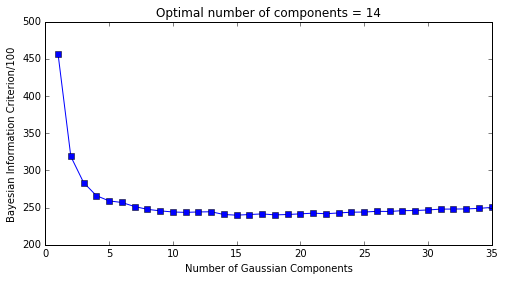

Saved GMM as lrgMag_gmm.fits.


In [9]:
make_gmm_model(lrgMag_data, components_range, model_filename='lrgMag_gmm.fits', bic_plot=True)

In [10]:
lrgMag_sample = sample_magnitudes('LRG', n_targets=len(lrgMag_data))

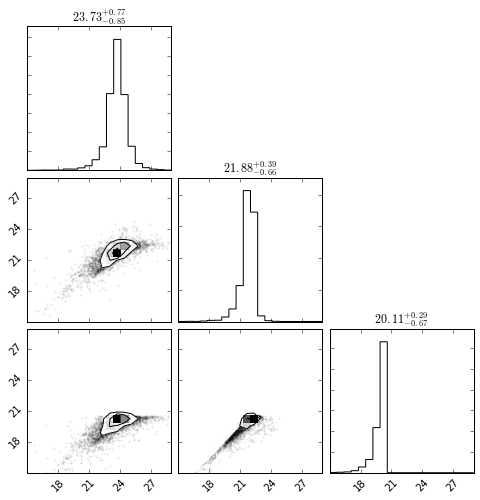

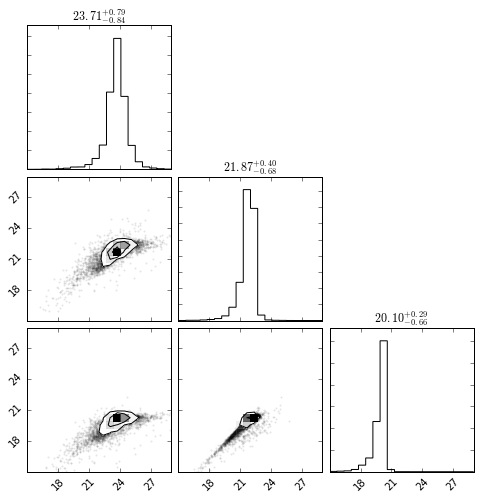

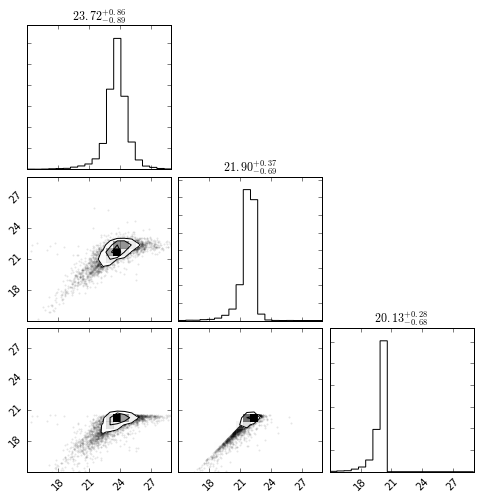

In [11]:
axes_range = [(15,29), (15,29), (15,29)]

#Data
fig1 = cn.corner(lrgMag_data, show_titles=True, title_kwargs={"fontsize": 12}, range=axes_range)
#Sample
fig2 = cn.corner(lrgMag_sample, show_titles=True, title_kwargs={"fontsize": 12}, range=axes_range)
#Cross-validation
fig3 = cn.corner(lrgMag_cross, show_titles=True, title_kwargs={"fontsize": 12}, range=axes_range)

### ELGs

In [12]:
elgMag_data = dr2_data(elg_data)
elgMag_cross = dr2_data(elg_cross)

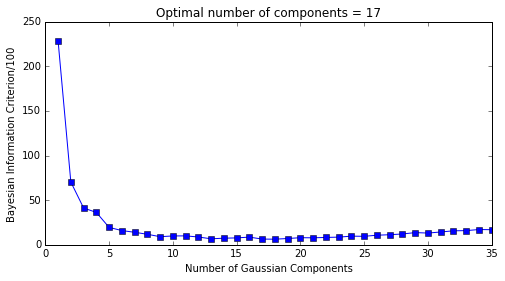

Saved GMM as elgMag_gmm.fits.


In [13]:
make_gmm_model(elgMag_data, components_range, model_filename='elgMag_gmm.fits', bic_plot=True)

In [17]:
elgMag_sample = sample_magnitudes('ELG', n_targets=len(elgMag_data))

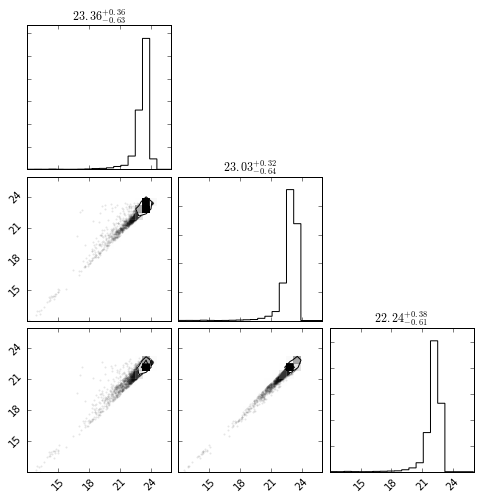

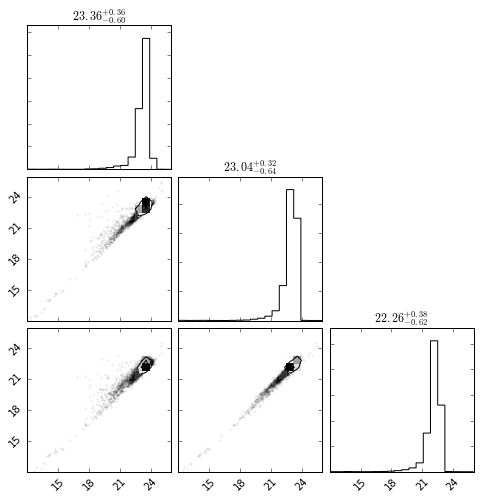

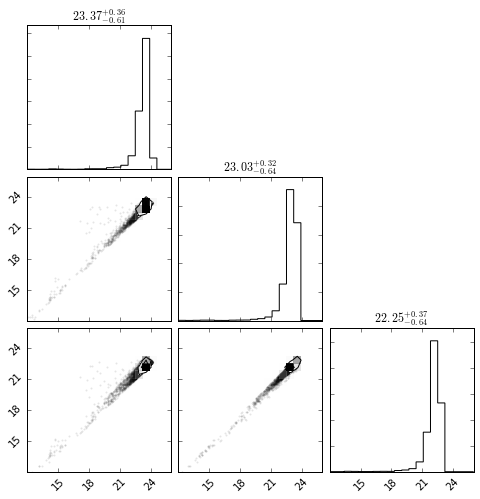

In [18]:
axes_range = [(12,26), (12,26), (12,26)]

#Data
fig1 = cn.corner(elgMag_data, show_titles=True, title_kwargs={"fontsize": 12}, range=axes_range)
#Sample
fig2 = cn.corner(elgMag_sample, show_titles=True, title_kwargs={"fontsize": 12}, range=axes_range)
#Cross-validation
fig3 = cn.corner(elgMag_cross, show_titles=True, title_kwargs={"fontsize": 12}, range=axes_range)

### QSOs

In [19]:
qsoMag_data = dr2_data(qso_data)
qsoMag_cross = dr2_data(qso_cross)

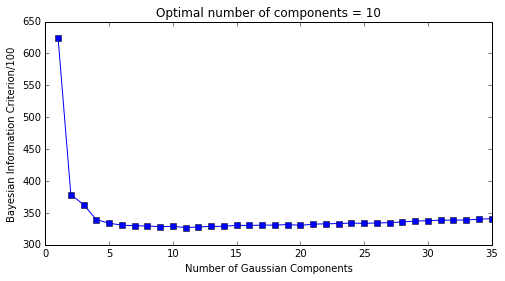

Saved GMM as qsoMag_gmm.fits.


In [20]:
make_gmm_model(qsoMag_data, components_range, model_filename='qsoMag_gmm.fits', bic_plot=True)

In [21]:
qsoMag_sample = sample_magnitudes('QSO', n_targets=len(qsoMag_data))

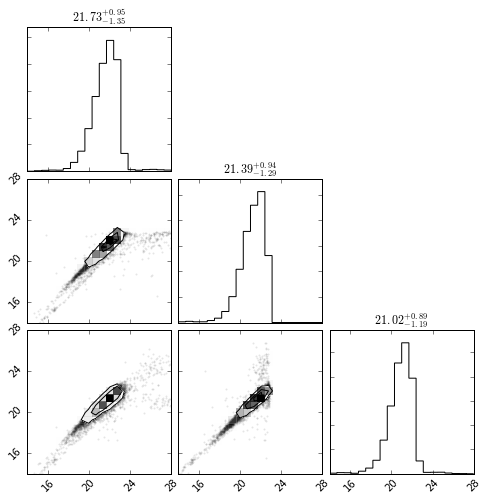

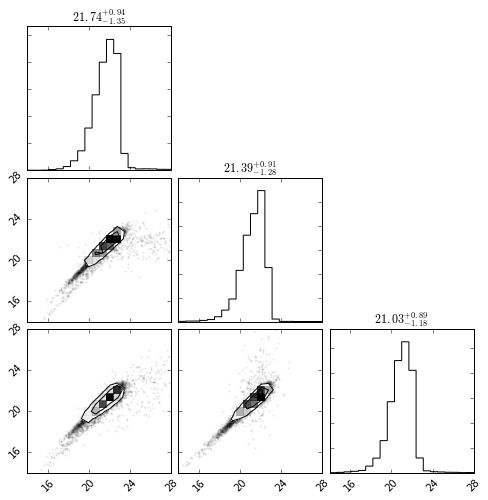

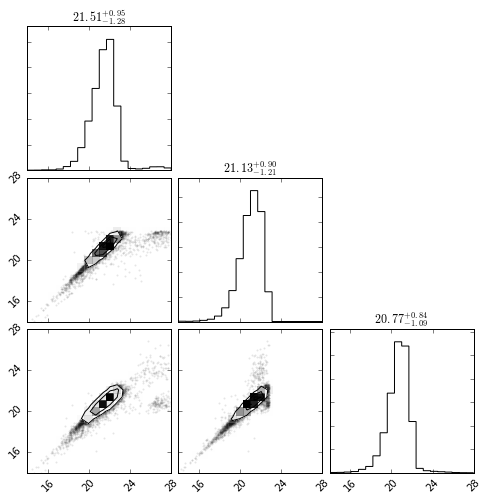

In [22]:
axes_range = [(14,28), (14,28), (14,28)]

#Data
fig1 = cn.corner(qsoMag_data, show_titles=True, title_kwargs={"fontsize": 12}, range=axes_range)
#Sample
fig2 = cn.corner(qsoMag_sample, show_titles=True, title_kwargs={"fontsize": 12}, range=axes_range)
#Cross-validation
fig3 = cn.corner(qsoMag_cross, show_titles=True, title_kwargs={"fontsize": 12}, range=axes_range)